In [1]:
!pip install numpy scipy scikit-learn pandas joblib --user

In [2]:
!pip install deap update_checker tqdm stopit xgboost --user


In [3]:
!pip install dask[delayed] dask[dataframe] dask-ml fsspec>=0.3.3 distributed>=2.10.0 --user


In [4]:
!pip install tpot --user

In [1]:
import csv
import glob
import logging
import os
from tempfile import TemporaryDirectory

#from osgeo import gdal
import joblib
import numpy as np
#from osgeo import osr
from scipy import sparse as sp
from sklearn import ensemble as ens
#from sklearn.externals import joblib as sklearn_joblib
from sklearn.model_selection import cross_val_score
#from osgeo import osr, ogr

import os, time
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import rasterio
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import os, time
from imblearn.under_sampling import RandomUnderSampler
from joblib import dump, load
import numpy as np
import rasterio
from rasterio.merge import merge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from tpot.export_utils import set_param_recursive

In [2]:
base_folder = '/scratch/project_2004990/jutilaee/mtk_kehitys/uusimaa'
csv_path = os.path.join(base_folder,'uusimaa_signatures_and_features_max_VH.csv')
model_path = os.path.join(base_folder,'uusimaa_model.pkl')

In [3]:
def load_signatures(sig_csv_path, sig_datatype=np.int32):
    """
    Extracts features and class labels from a signature CSV
    Parameters
    ----------
    sig_csv_path : str
        The path to the csv
    sig_datatype : dtype, optional
        The type of pixel data in the signature CSV. Defaults to np.int32

    Returns
    -------
    features : array_like
        a numpy array of the shape (feature_count, sample_count)
    class_labels : array_like of int
        a 1d numpy array of class labels corresponding to the samples in features.

    """
    data = np.genfromtxt(sig_csv_path, delimiter=",", dtype=sig_datatype).T
    return (data[1:, :].T, data[0, :])


In [4]:
features, labels = load_signatures(csv_path,np.float64)

In [5]:
# Predict on whole image and save it as .tif file
def predictImage(clf,modelName, predictImage):
    #Set file paths for input and output files
    predictedClassesFile = outputImageBase + modelName + '.tif'
    predictedClassesPath = os.path.join(results_folder, predictedClassesFile)
    
    # Read the satellite image
    with rasterio.open(predictImage, 'r') as image_dataset:
        start_time = time.time()    
        
        #Reshape data to 1D as we did before model training
        #image_data = image_dataset.read()
        image_data = image_dataset.read()
        image_data2 = np.transpose(image_data, (1, 2, 0))
        pixels = image_data2.reshape(-1, 27)
        
        #Load the model from the saved file
        #modelFilePath = os.path.join(base_folder, ('model_' + modelName + '.sav'))
        #trained_model = load(modelFilePath)
        
        # predict the class for each pixel
        prediction = clf.predict(pixels)
        
        # Reshape back to 2D
        print('Prediction shape in 1D: ', prediction.shape)
        prediction2D = np.reshape(prediction, (image_dataset.meta['height'], image_dataset.meta['width']))
        #prediction2D = np.reshape(prediction, ( 705, 1213))
        print('Prediction shape in 2D: ', prediction2D.shape)
        
        # Save the results as .tif file.
        # Copy the coorindate system information, image size and other metadata from the satellite image 
        outputMeta = image_dataset.meta
        # Change the number of bands and data type.
        #outputMeta.update(count=1, dtype='uint8')
        outputMeta.update(count=1, dtype='uint8', height=image_dataset.meta['height'], width=image_dataset.meta['width'])
        # Writing the image on the disk
        with rasterio.open(predictedClassesPath, 'w', **outputMeta) as dst:
            dst.write(prediction2D, 1)
        print('Predicting took: ', round((time.time() - start_time), 1), ' seconds')
 

In [6]:
#Set working directory and input/output file names.

data_folder = "/scratch/project_2004990/jutilaee/mtk_kehitys/uusimaa"

results_folder = "/scratch/project_2004990/jutilaee/mtk_kehitys/uusimaa/raster_classification_results_2"

base_folder = "/scratch/project_2004990/jutilaee/mtk_kehitys/uusimaa"
outputImageBase = 'forest_loss_tpot'

# Input
inputImage = '/scratch/project_2004990/jutilaee/mtk_kehitys/uusimaa/training_data/UM_max_VH_training.tif'


In [7]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=63)


In [12]:
pipeline_optimizer = TPOTClassifier(generations=10, population_size=50, cv=8,
                                    random_state=42, verbosity=2,  n_jobs=-1)

In [13]:
pipeline_optimizer.fit(x_train, y_train)

print(pipeline_optimizer.score(x_test, y_test))
pipeline_optimizer.export('tpot_exported_pipeline.py')

Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8655781434058898

Generation 2 - Current best internal CV score: 0.8655781434058898

Generation 3 - Current best internal CV score: 0.8655781434058898

Generation 4 - Current best internal CV score: 0.8655781434058898

Generation 5 - Current best internal CV score: 0.8681385915492957

Generation 6 - Current best internal CV score: 0.8681385915492957

Generation 7 - Current best internal CV score: 0.8681385915492957

Generation 8 - Current best internal CV score: 0.8681385915492957

Generation 9 - Current best internal CV score: 0.8681385915492957

Generation 10 - Current best internal CV score: 0.8681385915492957

Best pipeline: KNeighborsClassifier(MinMaxScaler(input_matrix), n_neighbors=3, p=1, weights=distance)


/usr/local/lib64/python3.9/site-packages/sklearn/metrics/_scorer.py:765: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(


0.8738998239718355


In [8]:
# Average CV score on the training set was: 0.8681385915492957
exported_pipeline = make_pipeline(
    MinMaxScaler(),
    KNeighborsClassifier(n_neighbors=3, p=1, weights="distance")
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

In [9]:
exported_pipeline.fit(x_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))])

In [10]:
results = exported_pipeline.predict(x_test)

In [11]:
print('Confusion matrix: \n', confusion_matrix(y_test, results))
print('Classification report: \n', classification_report(y_test, results))

Confusion matrix: 
 [[1505  465   22]
 [ 183 1699   22]
 [  39   57 2257]]
Classification report: 
               precision    recall  f1-score   support

         1.0       0.87      0.76      0.81      1992
         2.0       0.76      0.89      0.82      1904
         3.0       0.98      0.96      0.97      2353

    accuracy                           0.87      6249
   macro avg       0.87      0.87      0.87      6249
weighted avg       0.88      0.87      0.87      6249



<AxesSubplot: >

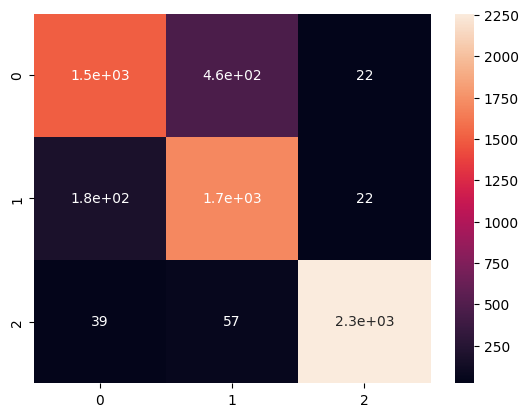

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, results)

import seaborn as sns

sns.heatmap(cm, annot=True)

In [17]:
predictImage(exported_pipeline,'_training',inputImage)

Prediction shape in 1D:  (1168710,)
Prediction shape in 2D:  (815, 1434)
Predicting took:  648.2  seconds


In [ ]:
inputImage = '/scratch/project_2004990/jutilaee/mtk_kehitys/uusimaa/UM_max_VH.tif'
predictImage(exported_pipeline,'_whole_uusimaa',inputImage)